## Download and check rdf2vec

In [4]:
training = 1
VECTOR_SIZE=100
test_classic_ml = False
CLASSIFIER_EPOCHS = 50

In [2]:
# download jrdf2vec
! wget -nc https://raw.githubusercontent.com/dwslab/jRDF2Vec/jars/jars/jrdf2vec-1.3-SNAPSHOT.jar

File ‘jrdf2vec-1.3-SNAPSHOT.jar’ already there; not retrieving.



In [7]:
# Check jrdf2vec installation. Should print "=> Everything is installed. You are good to go!" somewhere
if training:
    ! java -jar jrdf2vec-1.3-SNAPSHOT.jar -checkInstallation

Using server port: 1808
05 Sep 2023 18:28:28 DEBUG [main] (RequestAddCookies.java:123) - CookieSpec selected: default
05 Sep 2023 18:28:28 DEBUG [main] (RequestAuthCache.java:77) - Auth cache not set in the context
05 Sep 2023 18:28:28 DEBUG [main] (PoolingHttpClientConnectionManager.java:267) - Connection request: [route: {}->http://127.0.0.1:1808][total available: 0; route allocated: 0 of 2; total allocated: 0 of 20]
05 Sep 2023 18:28:28 DEBUG [main] (PoolingHttpClientConnectionManager.java:312) - Connection leased: [id: 0][route: {}->http://127.0.0.1:1808][total available: 0; route allocated: 1 of 2; total allocated: 1 of 20]
05 Sep 2023 18:28:28 DEBUG [main] (MainClientExec.java:234) - Opening connection {}->http://127.0.0.1:1808
05 Sep 2023 18:28:28 DEBUG [main] (DefaultHttpClientConnectionOperator.java:139) - Connecting to /127.0.0.1:1808
05 Sep 2023 18:28:28 DEBUG [main] (LoggingManagedHttpClientConnection.java:96) - http-outgoing-0: Shutdown connection
05 Sep 2023 18:28:28 DEBU

## Download Dataset


In [4]:
# download .nt dataset from my drive
! wget -q -nc --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pBnn8bjI2VkVvBR33DnvpeyocfDhMCFA' -O fb15k-237_nt.zip

! unzip -n fb15k-237_nt.zip

Archive:  fb15k-237_nt.zip


## Generate walks and train rdf2vec

In [6]:
# generate walks and train rdf2vec on train set with default parameters
if training:
    ! rm -rf walks
    ! java -jar jrdf2vec-1.3-SNAPSHOT.jar -walkDirectory walks -graph FB15k-237/train.nt -threads 10 -dimension 100

Using server port: 1808
The specified walk directory does not exist. Trying to make the directory.
Using 10 threads for walk generation and training.
Using vector dimension: 100
Using depth 4
Generating 100 walks per entity.
RDF2Vec Classic
05 Sep 2023 18:21:14  INFO [main] (WalkGeneratorManager.java:64) - Using NxParser.
05 Sep 2023 18:21:15  INFO [main] (WalkGeneratorManager.java:99) - Model read into memory.
05 Sep 2023 18:21:17  INFO [pool-1-thread-5] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 1000
05 Sep 2023 18:21:17  INFO [pool-1-thread-5] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 89615
05 Sep 2023 18:21:19  INFO [pool-1-thread-10] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 2000
05 Sep 2023 18:21:19  INFO [pool-1-thread-10] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 180670
05 Sep 2023 18:21:20  INFO [pool-1-thread-1] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 3000
05 Sep 2023 18:21:20  INFO [p

In [6]:
import numpy as np
import gc

def get_entities(graphs):
    # get subjects and objects
    entities = []
    
    for g in graphs:
        entities = entities + list(g.subjects(unique=True)) + list(g.objects(unique=True))

    # pythons stupid version of nub
    entities = list(dict.fromkeys(entities))
    return entities

def get_all_corrupted_triples_fast(triple,entities,position = 'object'):
    # not faster ...

    s,p,o = triple

    object_augmented = [(x,y,z) for  (x,y), z in itertools.product([triple[0:2]],entities)]
    subject_augmented =[(x,y,z) for  x, (y,z) in itertools.product(entities,[triple[1:3]])]
    
    
    return itertools.chain(object_augmented , subject_augmented)

def get_all_corrupted_triples(triple,entities):
    #too slow ....
    
    s,p,o = triple
    subject_corrupted = [(s_corr,p,o) for s_corr in entities if s_corr != s]
    object_corrupted = [(s,p,o_corr)   for o_corr in entities if o_corr != o]

    return subject_corrupted + object_corrupted


    

def choose_many_multiple(arrs,n):
    l = len(arrs[0])
    for a in arrs:
        assert len(a) == l, 'Arres not of same length ! :('
        
    
    ix = np.random.choice(range(len(a)),n)
    
    return [np.array(a)[ix] for a in arrs]
    
def choose_many(a,n):
    ix = np.random.choice(range(len(a)),n)
    return np.array(a)[ix]
    
def choose(a):

    L = len(a)

    i = np.random.randint(0,L)

    return a[i]

def get_random_corrupted_triple(triple,entities, corrupt='object'):
    """
    corrupt = one of 'subject', 'object', 'both'
    
    return corrupted triple with random entity
    """

    s,p,o = triple
    
    # set up as the same
    s_corr = s
    o_corr = o
    
    if corrupt == 'subject':  
        # corrupt only the subject
        while s_corr == s:
            s_corr = choose(entities)  
    elif corrupt == 'object':
        # corrupt only the object
        while o_corr == o:
            o_corr = choose(entities)  
    elif corrupt == 'random':
        # corrupt one or both randomly
        ch = np.random.randint(3)
        
        if ch == 0:
            while s_corr == s:
                s_corr = choose(entities)  
        if ch == 1 :
            while o_corr == o:
                o_corr = choose(entities)  
        if ch == 2:
            while s_corr == s or o_corr == o:
                s_corr = choose(entities)  
                o_corr = choose(entities) 
    else:
        while s_corr == s or o_corr == o:
            s_corr = choose(entities)  
            o_corr = choose(entities) 
            
    
    return (s_corr,p,o_corr)
    
def merge_historires(history_list):
    h = {}
    for key in history_list[0].history.keys():
        h[key] = [h.history[key][0] for h in histories]
    return h    


def clean_graph(graph,wv):
    """
    clean graph such that all triples have word vectors present in wv
    
    """
    no_removed = 0 
    for t in graph:
        s,p,o = t
        if not str(s) in wv.key_to_index.keys() or not str(p) in wv.key_to_index.keys() or not str(o) in wv.key_to_index.keys():
            graph.remove(t)
            no_removed+=1
    return no_removed
    
    
def get_vectors_fast(triples,entity_vec_mapping,vector_size=VECTOR_SIZE):
    # ~20-30% faster
    X = np.array(triples)
    X = word_vectors[X.flatten()].reshape(len(triples),vector_size*3)
    
    return X    

def get_vectors(triples,entity_vec_mapping,vector_size=200):
    X = np.array(triples)
    X = [(entity_vec_mapping(x[0]), entity_vec_mapping(x[1]),entity_vec_mapping(x[2])) for x in X]
    X = [np.concatenate(x) for x in X]
    X = np.vstack(X).astype(np.float64)
    
    return X

def get_1_1_dataset(graph, entities,entity_vec_mapping,corrupt='random'):
    
    original_triple_len = len(graph)
    # get triples
    X = list(graph)
    no_t = len(X)
    

    
    corrupted_triples = [get_random_corrupted_triple(x,entities,corrupt=corrupt) for x in X]
    X = X + corrupted_triples
    
    

    # convert uris to strings
    
    X = get_vectors_fast(X,entity_vec_mapping)
    
    # stack them

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y

def test_sklearn_model(model,X,Y,x_test,y_test,subset=10000):
    

  
    
    ix = np.random.choice(range(len(X)),size=subset)
    
    scaler = preprocessing.StandardScaler().fit(X)
    
    X_scaled = scaler.transform(X[ix])
    model.fit(X_scaled,Y[ix])

    print(f'train_score ={model.score(scaler.transform(X),Y)}')    
    print(f'test_score ={model.score(scaler.transform(x_test),y_test)}')

def scale_and_predict(model,x):
    x = preprocessing.StandardScaler().fit_transform(x)
    return model.predict(x)

## Parse Graph

In [7]:
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx



g_train = Graph()
g_val = Graph()
g_test = Graph()

g_train = g_train.parse('FB15k-237/train.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid.nt', format='nt')
g_test  = g_test.parse('FB15k-237/test.nt', format='nt')


In [8]:
len(set(np.array(list(g_train.predicates()))))

237

## Plot Graph (not working)

In [9]:
# taken from https://stackoverflow.com/questions/39274216/visualize-an-rdflib-graph-in-python
# takes way too long ... use subgraph?!
import matplotlib.pyplot as plt
plot = False
if plot:
    G = rdflib_to_networkx_multidigraph(g_train[0:100])


    pos = nx.spring_layout(G, scale=2)
    edge_labels = nx.get_edge_attributes(G, 'r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw(G, with_labels=True)

    #if not in interactive mode for 
    plt.show()
    

In [10]:
from gensim.models import Word2Vec


word_vectors = Word2Vec.load('walks/model').wv

In [11]:
def map_keyed_vectors(word_vectors, iterable):
    """
    for some reason faster than native call :O
    """
    return np.array(list(word_vectors.get_vector(x) for x in iterable))

In [12]:
# clean graphs 
# number of triples removed should be low, a few hundred
print(f"removed {clean_graph(g_train,word_vectors)} triples from training set")
print(f"removed {clean_graph(g_val,word_vectors)} triples from validation set")
print(f"removed {clean_graph(g_test,word_vectors)} triples from test set")

entities = get_entities((g_train,g_val,g_test))

removed 259 triples from training set
removed 37 triples from validation set
removed 59 triples from test set


In [13]:
'http://example.org/m/057hz'

'http://example.org/m/057hz'

In [14]:
ent_vecs = word_vectors[np.array(entities)]

In [15]:
entities[0]

rdflib.term.URIRef('http://example.org/m/04kxsb')

In [16]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x])
x_val , y_val= get_1_1_dataset(g_val,entities,lambda x : word_vectors[x])
x_test , y_test= get_1_1_dataset(g_test,entities,lambda x : word_vectors[x])

print(f"training datapoints = {len(X)}")
print(f"validation datapoints = {len(x_val)}")
print(f"test datapoints = {len(x_test)}")

training datapoints = 543712
validation datapoints = 34996
test datapoints = 40814


In [17]:
# test some simple baselines\
import sklearn.linear_model
import sklearn.ensemble
from sklearn import preprocessing



In [18]:
if test_classic_ml:
    # 0.6 is pretty bad
    LR = sklearn.linear_model.LogisticRegression(max_iter=1000)
    test_sklearn_model(LR,X,Y,x_test,y_test,10000)


In [19]:
if test_classic_ml:
    # this works pretty well out of the box
    randomforest = sklearn.ensemble.RandomForestClassifier()
    test_sklearn_model(randomforest,X,Y,x_test,y_test,10000)

In [20]:
def get_1_1_dataset(graph, entities,entity_vec_mapping,corrupt='random'):
    
    original_triple_len = len(graph)
    # get triples
    X = list(graph)
    no_t = len(X)
    

    
    corrupted_triples = [get_random_corrupted_triple(x,entities,corrupt=corrupt) for x in X]
    X = X + corrupted_triples
    
    

    # convert uris to strings
    
    X = get_vectors_fast(X,entity_vec_mapping)
    
    # stack them

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y

In [21]:
def get_random_corrupted_triple_embedded(triple,entities, corrupt='object',vector_size=VECTOR_SIZE):
    """
    corrupt = one of 'subject', 'object', 'both'
    
    return corrupted triple with random entity
    """

    
    s = triple[0:VECTOR_SIZE]
    p = triple[VECTOR_SIZE:VECTOR_SIZE*2]
    o = triple[VECTOR_SIZE*2:]
    
    # set up as the same
    s_corr = s[:]
    o_corr = o[:]

    if corrupt == 'subject':  
   
        # corrupt only the subject
        while (s_corr == s).all():
            s_corr = choose(entities)  
    elif corrupt == 'object':
        # corrupt only the object
        while (o_corr == o).all():
            o_corr = choose(entities)  
    elif corrupt == 'random':
        # corrupt one or both randomly
        ch = np.random.randint(3)
        
        if ch == 0:
            while (s_corr== s).all():
                s_corr = choose(entities)  
        if ch == 1 :
            while (o_corr == o).all():
                o_corr = choose(entities)  
        if ch == 2:

            while (s_corr == s).all() or (o_corr == o).all():
                s_corr = choose(entities)  
                o_corr = choose(entities) 
    else:

        while (s_corr == s).all() or (o_corr == o).all():
            s_corr = choose(entities)  
            o_corr = choose(entities) 
            
    
    return np.concatenate((s_corr,p,o_corr),axis=0)

def get_1_1_dataset_embedded(graph, entities,corrupt='random', vector_size=VECTOR_SIZE):
    """
    graph: numpy array of shape (samples,3*
    """
  
    if len(graph.shape) == 1:
        graph = np.expand_dims(graph,0)
    #print(graph.shape)
    no_t = len(graph)
    corrupted_triples = [get_random_corrupted_triple_embedded(x,entities,corrupt=corrupt,vector_size=vector_size) for x in graph]
    X = np.concatenate((graph,corrupted_triples),axis=0)

    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y
import torch
class Dataset11(torch.utils.data.Dataset):
    def __init__(self,graph,vec_mapping,entities,corrupt='random',vector_size=VECTOR_SIZE):
        """
        graph: graph to train on
        vec_mapping: function that returns vectos from URIs
        entities: iterable of all entities to build fake triples
        """
        
        
        self.entities = vec_mapping(np.array(entities))        
        self.graph = get_vectors_fast(graph,vec_mapping)
        self.len = len(graph)
        self.vec_mapping = vec_mapping
        self.corrupt = corrupt
        self.vector_size = vector_size

        
    def __len__(self) :
        return self.len
    def __getitem__(self,ix):
        return get_1_1_dataset_embedded(self.graph[ix],self.entities,self.corrupt,self.vector_size)



In [22]:
from tqdm import trange,tqdm
from collections import defaultdict
from torch.utils.data import DataLoader

def fit_1_1(model,graph,word_vec_mapping,batch_size,entities,metrics=None,epochs=50,optimizer=None,lossF= torch.nn.BCEWithLogitsLoss(),graph_eval=None):
    """
    metrics: dictionary of {name:torchmetric} to track for training and evaluation.
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # move metrics to device 
    metrics = {name:metric.to(device) for (name,metric) in metrics.items()}
    
    # move model to device

    model = model.to(device)
    
    if not optimizer:
        optimizer = torch.optim.Adam(model.parameters())
    
    history = defaultdict(list)
    loss_metric = torchmetrics.aggregation.MeanMetric().to(device)
    
    dataset = Dataset11(graph,word_vec_mapping,entities,'random')
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    if graph_eval:
        dataset_eval = Dataset11(graph_eval,word_vec_mapping,entities,'random')
        dataloader_eval = DataLoader(dataset_eval,batch_size=batch_size,shuffle=False)
    
    for ep in trange(epochs):
        # train 
        for X,Y in dataloader:
            model.train()
            
            # shape is (bs,2,3*VECTORSIZE) because of dataset implementation
            # so I need to flatten the arrays
            X = torch.flatten(X,0,1)
            Y = torch.flatten(Y)

            X = X.to(device)
            Y = Y.to(device).double()
            
            predictions = model(X).squeeze()
            loss = lossF(predictions,Y)
            loss_metric(loss)          
            
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            for metric in metrics.values():
                metric(predictions,Y.long())
            
            
        for name, metric in metrics.items():
            history[name].append(metric.compute())
            metric.reset()
        history['loss'].append(loss_metric.compute() )   
        loss_metric.reset() 
            
        # eval
        if graph_eval:
            with torch.no_grad():
                for X,Y in dataloader:
                    model.eval()

                    # shape is (bs,2,3*VECTORSIZE) because of dataset implementation
                    # so I need to flatten the arrays
                    X = torch.flatten(X,0,1)
                    Y = torch.flatten(Y)

                    X = X.to(device)
                    Y= Y.to(device).double()


                    predictions = model(X).squeeze()
                    loss = lossF(predictions,Y)
                    loss_metric(loss)


                    for metric in metrics.values():
                        metric(predictions,Y.long())

                for name, metric in metrics.items():
                    history[name+'_val'].append(metric.compute())
                    metric.reset()
                history['loss_val'].append(loss_metric.compute())
                loss_metric.reset() 
    # tensor - > float conversion
    history = {k: [x.item() for x in v] for (k,v) in history.items()}
    return model, history
    

In [23]:
# pytorch model
import torchmetrics
import torch
from torch import nn 


class ClassifierSimple(torch.nn.Module):
    def __init__(self,input_dim=300,hidden_size=64):
        super(ClassifierSimple, self).__init__()
        
        
        self.layers = nn.Sequential(
                # flatten input if necessary
                nn.Flatten(),
                nn.Linear(input_dim,hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size,1)
        )
        
        self.output_activation = nn.Sigmoid()
                
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
        
    
    def forward(self,x):        
        
        return self.layers(x)
    def predict(self,x):
        x.to(self.device)
        
        return self.output_activation(self.layers(x))
    def predict_numpy(self,x):
        x = torch.tensor(x)
        x.to(self.device)
        return self.output_activation(self.layers(x)).detach().cpu().numpy()
        
    


2022-11-07 13:52:58.075705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 13:52:58.075738: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
torch.get_num_threads()

6

In [25]:
from pathlib import Path
import pandas as pd
model = ClassifierSimple()    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if Path('rdf2vecClassfier.pth').is_file():
    print('found trained model! Loading :)')
    model.load_state_dict(torch.load('rdf2vecClassfier.pth'))
    history = pd.read_csv('log.csv')
    model = model.to(device)
else:
    model = model.to(device)
    model,history = fit_1_1(model,g_train,lambda x: word_vectors[x],3000,entities,metrics = {'acc' :torchmetrics.classification.Accuracy()},graph_eval=g_val,epochs=300)
    model.eval()
    torch.save(model.state_dict(),'rdf2vecClassfier.pth')

found trained model! Loading :)


<AxesSubplot:>

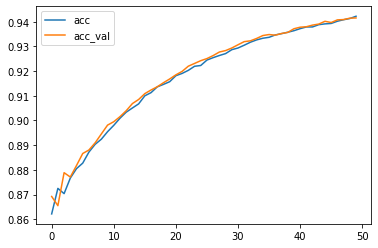

In [26]:
pd.DataFrame(history)[['acc','acc_val']].plot()

<AxesSubplot:>

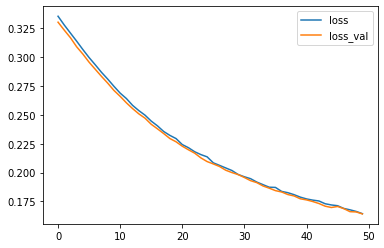

In [27]:
pd.DataFrame(history)[['loss','loss_val']].plot()